----
## **<font color="crimson"> Creo que este sobra</font>**

In [31]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install h5netcdf 

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install cmcrameri

Note: you may need to restart the kernel to use updated packages.


In [36]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import math
from collections import Counter
from cmcrameri import cm

In [37]:
def contour_f(data,contourdata,levels=np.arange(0,11),ccmap='PuBu',extend='max',limite_NS=42,clevels=np.arange(230,300,15),titulo='OLR y pr',cbarlabel='pr  [mm day$^{-1}$]'):
    lons,lats=data.lon,data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    contourdata, lon = add_cyclic_point(contourdata, coord=lons)
    fig = plt.figure(figsize=(10, 6))

    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    cs=ax.contourf(lon,lats,data,levels=levels,cmap=ccmap,extend=extend,transform=ccrs.PlateCarree())
    cc=ax.contour(lon,lats,contourdata,levels=clevels,colors='k',transform=ccrs.PlateCarree())

    ax.clabel(cc, cc.levels, inline=True, fontsize=10)

    ax.set_extent([-180,180, -limite_NS, limite_NS], crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True,color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    plt.title(titulo,fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.046, pad=0.06)
    cbar.ax.set_xlabel(cbarlabel)

### **<font color="Purple"> Datos de HadGEM3 </font>**

##### **<font color="olive"> Temperatura </font>**

In [38]:
tas_file = 'datasets/tasday79.nc'

In [39]:
#archivo historical
tas_ds=xr.open_dataset(tas_file)
tas=tas_ds['tas']

In [40]:
# Promedio de temperatura por estación 
tas_estacion=tas.groupby(tas.time.dt.season).mean(dim='time') #tas ya está a partir de 1979
tas_djf = tas_estacion[0]

In [41]:
tas_inviernos = tas.sel(time=tas['time.month'].isin([12, 1, 2]))

In [42]:
latsHG=tas.lat
lonsHG=tas.lon

##### **<font color="olive"> Viento </font>**

In [16]:
u_99= 'datasets/uaday200hpa_99_mx.nc'
u_14='datasets/uaday200hpa_14_mx.nc'

In [17]:
# Abrir archivos y seleccionar variables a usar 
u_ds99=xr.open_dataset(u_99)
ua99=u_ds99['ua']  
u_ds14=xr.open_dataset(u_14)
ua14=u_ds14['ua']

In [18]:
uHG = xr.concat([ua99, ua14], dim='time')

In [19]:
latsuHG = ua99.lat
lonsuHG = ua99.lon

In [20]:
u_seasonHG=uHG.groupby(uHG.time.dt.season).mean(dim='time') 
u_DJFHG = u_seasonHG[0]

In [21]:
u_inviernosHG = uHG.sel(time=uHG ['time.month'].isin([12, 1, 2]))

### **<font color="Purple"> Datos de ERA-5 </font>**

##### **<font color="olive"> Temperatura </font>**

In [22]:
filet2m_era5 = 'datasets/t2m_daily.nc'

In [23]:
t2m_ds=xr.open_dataset(filet2m_era5)
t2m=t2m_ds['t2m']

In [24]:
t2m=t2m-273.15

In [25]:
# Calcular promedio estacional
t2m_estacion=t2m.groupby(t2m.time.dt.season).mean(dim='time') 
t2m_anual = t2m.groupby(t2m.time.dt.year).mean(dim='time').mean(dim='year')

In [26]:
#seleccionar inviernos
invs_E5 = t2m_estacion[0]

In [27]:
latsE5_t=t2m.latitude
lonsE5_t=t2m.longitude

In [28]:
t2m_inviernos = t2m.sel(time=t2m['time.month'].isin([12, 1, 2]))

##### **<font color="olive"> Viento </font>**

In [51]:
fileu_era5 = 'datasets/u_200_500_daily1979-2019.nc'

In [52]:
u_ds = xr.open_dataset(fileu_era5)
u_era5 = u_ds['u']

In [53]:
lonsuE5 = u_era5.longitude
latsuE5 = u_era5.latitude

In [ ]:
#Seleccionar solo 200 hPa 
u200E5 = u_era5.sel(level=200)

In [ ]:
u200E5_anual=u200E5.mean(dim='time') 

In [ ]:
u200E5_season = u200E5.groupby(u200E5.time.dt.season).mean(dim='time')
uE5_DJF = u200E5_season[0]

In [ ]:
u_inviernosE5 = u200E5.sel(time=u200E5['time.month'].isin([12, 1, 2]))

### **<font color="olive"> CAOs de HadGEM </font>**

In [54]:
def CAOS_MX(Tdias):
    mean = Tdias.mean()
    desv_est = Tdias.std()
    condicionCAO = mean - 2 * desv_est  
    dias_CAO = []
    temp_list = []

    for i in range(len(Tdias) - 1):
        if Tdias[i] < condicionCAO and Tdias[i + 1] < condicionCAO:
            dias_CAO.append(i)
            dias_CAO.append(i + 1)
            dias_CAOS = pd.DataFrame(dias_CAO).drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
    
    # Obtener las fechas correspondientes usando los índices
    dias_CAO_dates = Tdias['time'].values[dias_CAO]

    # Convertir las fechas a un calendario gregoriano estándar 
    fechas_CAO_datetime = pd.to_datetime([str(date) for date in dias_CAO_dates],errors='coerce')    
    fechas_indices = {fecha: dias_CAO[i] for i, fecha in enumerate(fechas_CAO_datetime)}
    
    # Imprimir las fechas y sus índices
    for fecha, indice in fechas_indices.items():
        temperatura = Tdias[indice].values 
        temp_list.append(temperatura)
     #   print(f"Índice: {indice}, Fecha: {fecha}, Temperatura: {temperatura}")
    
    #print(pd.DataFrame(dias_CAO).drop_duplicates().size)
    #print(len(fechas_CAO_datetime),len(dias_CAO),len(dias_CAO_dates))
    promedioT=np.mean(temp_list)
    
    dicc={'fechas':fechas_indices,'temperaturas':temp_list,'freq':len(dias_CAOS)/36,'promedioT':promedioT}
    
    return dicc

In [55]:
#Elegir un cuadro de 4x4
latitudes = tas_inviernos.sel(lat=slice(22,27))
longitudes = latitudes.sel(lon=slice(255,262))

In [56]:
weights = np.cos(np.deg2rad(longitudes))
weights.name = "weights"

In [57]:
tas_weighted = longitudes.weighted(weights)

In [58]:
weights

<xarray.DataArray 'weights' (time: 3240, lat: 4, lon: 4)> Size: 207kB
array([[[0.9871605 , 0.99271417, 0.9762576 , 0.954101  ],
        [0.9936825 , 0.988893  , 0.9688684 , 0.960655  ],
        [0.9886951 , 0.98045164, 0.9695055 , 0.96517336],
        [0.98676896, 0.9795889 , 0.96536595, 0.96647877]],

       [[0.9884575 , 0.9963707 , 0.9846671 , 0.95895684],
        [0.9948121 , 0.99226385, 0.9829956 , 0.96631116],
        [0.99618965, 0.99028724, 0.9799267 , 0.9727559 ],
        [0.9926018 , 0.9862753 , 0.97982293, 0.97792053]],

       [[0.98690814, 0.9914117 , 0.97805125, 0.95196015],
        [0.9930265 , 0.9867482 , 0.97502   , 0.9588649 ],
        [0.9927116 , 0.98193353, 0.9685829 , 0.96593064],
        [0.9870295 , 0.9753502 , 0.97091246, 0.97059226]],

       ...,

       [[0.98401517, 0.9897723 , 0.976168  , 0.94495726],
        [0.9880564 , 0.9860883 , 0.9749746 , 0.9629939 ],
        [0.9883287 , 0.9855217 , 0.9765603 , 0.97187674],
        [0.9881259 , 0.98193276, 0.9710266 , 0.9772269 ]],

       [[0.9833746 , 0.99102575, 0.97647864, 0.9528434 ],
        [0.98787254, 0.98952407, 0.9764483 , 0.9690969 ],
        [0.98800516, 0.9871911 , 0.9793079 , 0.96885365],
        [0.98904693, 0.9882552 , 0.98033327, 0.9781515 ]],

       [[0.9841084 , 0.99183106, 0.9726966 , 0.9386835 ],
        [0.988867  , 0.99033755, 0.96791506, 0.9507022 ],
        [0.9902932 , 0.9852188 , 0.96797925, 0.959121  ],
        [0.98918736, 0.98661023, 0.9760402 , 0.9678475 ]]], dtype=float32)
Coordinates:
  * time     (time) object 26kB 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lon      (lon) float64 32B 255.9 257.8 259.7 261.6
  * lat      (lat) float64 32B 23.12 24.38 25.62 26.88
    height   float64 8B ...

In [59]:
norte = tas_weighted.mean(['lon','lat']) 

In [60]:
CAOsHG = CAOS_MX(norte) #esto llamó a mi función con el que ya está pesado
fechas_caoHG = CAOsHG['fechas']

In [62]:
len(fechas_caoHG)

77

In [ ]:
CAOsHG 

In [40]:
indicesHG=[fechas_caoHG[key] for key in CAOsHG['fechas'].keys()]

In [41]:
tempsHG = tas_inviernos.isel(time=indicesHG)

In [42]:
tempsCAOHG=tempsHG.mean('time')

In [43]:
anomaliaHG = tempsCAOHG - tas_djf

In [44]:
#VIENTO
u_et_caoHG = u_inviernosHG.isel(time=indicesHG)

In [45]:
vientoCAOHG = u_et_caoHG.mean('time')

In [46]:
u_anomaliaHG = vientoCAOHG - u_DJFHG

### **<font color="olive"> CAOs de ERA-5</font>**

In [63]:
def E5_CAOS_MX(Tdias):
    """
    Esta función identifica los días cuando se cumple la condición de CAO (Cold Air Outbreak)
    y devuelve las fechas correspondientes en un calendario estándar.
    
    Parámetros:
    - Tdias (xarray.DataArray): Temperatura diaria en invierno durante ~30 años.
    
    Retorna:
    - lista de fechas
    - medidas de frecuencia de caos.
    - temperatura
    """
    mean = Tdias.mean()
    desv_est = Tdias.std()
    condicionCAO = mean - 2 * desv_est  
    dias_CAO = []
    temp_list = []
    #print(condicionCAO)
    #return
    for i in range(len(Tdias) - 1):
        if Tdias[i] < condicionCAO and Tdias[i + 1] < condicionCAO:
            dias_CAO.append(i)
            dias_CAO.append(i + 1)
            dias_CAOS = pd.DataFrame(dias_CAO).drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
    
    # Obtener las fechas correspondientes usando los índices
    dias_CAO_dates = Tdias['time'].values[dias_CAO]

    # Convertir las fechas a un calendario gregoriano estándar 
    fechas_CAO_datetime = pd.to_datetime([str(date) for date in dias_CAO_dates],errors='coerce')    
    fechas_indices = {fecha: dias_CAO[i] for i, fecha in enumerate(fechas_CAO_datetime)}
    
    # Imprimir las fechas y sus índices
    for fecha, indice in fechas_indices.items():
        temperatura = Tdias[indice].values 
        temp_list.append(temperatura)

    promedioT=np.mean(temp_list)
    
    # dicc={'fechas':fechas_indices,'temperaturas':temp_list,'freq':len(dias_CAOS)/36,'promedioT':promedioT}
    
    return {'fechas':fechas_indices,'temperaturas':temp_list,'freq':len(dias_CAOS)/36,'promedioT':promedioT}

In [64]:
#Elegir un cuadro de 4x4 (el mismo de las simulaciones)
mx_slicedE5 = t2m_inviernos.sel(latitude=slice(27,22)) 
mx_slicedE5 = mx_slicedE5.sel(longitude=slice(255,262)) 

In [65]:
weights = np.cos(np.deg2rad(mx_slicedE5))
weights.name = "weights"

In [66]:
t2m_weighted = mx_slicedE5.weighted(weights)

In [67]:
norteE5 = t2m_weighted.mean(['longitude','latitude']) #promedio a variable ya pesada
norteE5 

<xarray.DataArray 't2m' (time: 3669)> Size: 29kB
array([12.70385005,  5.15118216,  4.68601582, ..., 18.57529558,
       19.898325  , 20.90318976])
Coordinates:
  * time     (time) datetime64[ns] 29kB 1979-01-01T11:30:00 ... 2019-02-28T11...

In [68]:
CAOsE5 = E5_CAOS_MX(norteE5) #esto llamó a mi función con el que ya está pesado
fechas_caoE5 = CAOsE5['fechas']

In [72]:
CAOsE5

{'fechas': {Timestamp('1979-01-02 11:30:00'): 1,
  Timestamp('1979-01-03 11:30:00'): 2,
  Timestamp('1981-01-17 11:30:00'): 197,
  Timestamp('1981-01-18 11:30:00'): 198,
  Timestamp('1981-01-19 11:30:00'): 199,
  Timestamp('1981-01-22 11:30:00'): 202,
  Timestamp('1981-01-23 11:30:00'): 203,
  Timestamp('1983-12-29 11:30:00'): 448,
  Timestamp('1983-12-30 11:30:00'): 449,
  Timestamp('1983-12-31 11:30:00'): 450,
  Timestamp('1985-01-03 11:30:00'): 544,
  Timestamp('1985-01-04 11:30:00'): 545,
  Timestamp('1985-01-05 11:30:00'): 546,
  Timestamp('1985-01-06 11:30:00'): 547,
  Timestamp('1985-01-13 11:30:00'): 554,
  Timestamp('1985-01-14 11:30:00'): 555,
  Timestamp('1985-01-21 11:30:00'): 562,
  Timestamp('1985-01-22 11:30:00'): 563,
  Timestamp('1986-01-08 11:30:00'): 639,
  Timestamp('1986-01-09 11:30:00'): 640,
  Timestamp('1986-01-10 11:30:00'): 641,
  Timestamp('1987-01-12 11:30:00'): 733,
  Timestamp('1987-01-13 11:30:00'): 734,
  Timestamp('1987-01-21 11:30:00'): 742,
  Timestam

In [71]:
len(fechas_caoE5)

69

In [53]:
E5_listindex=[fechas_caoE5[key] for key in CAOsE5['fechas'].keys()]

In [54]:
tempsE5 = t2m_inviernos.isel(time=E5_listindex)

In [55]:
tempsCAOE5=tempsE5.mean('time')
tempsCAOE5 #es el promedio del total de CAOS

<xarray.DataArray 't2m' (latitude: 89, longitude: 259)> Size: 184kB
array([[ 6.15594968,  6.22239109,  6.28680288, ..., 12.66278659,
        12.74966968, 12.81437049],
       [ 6.44603482,  6.51367893,  6.57845647, ..., 12.95981316,
        13.05530082, 13.11482127],
       [ 6.78290771,  6.84218098,  6.88389287, ..., 13.2798331 ,
        13.3533852 , 13.41670017],
       ...,
       [26.11293347, 26.07843185, 26.06230556, ..., 25.68032192,
        25.66120457, 25.63523072],
       [26.0815354 , 26.04078009, 26.01010095, ..., 25.68670601,
        25.66002498, 25.65546407],
       [26.06837463, 26.03716864, 26.01327089, ..., 25.73783328,
        25.72546081, 25.72180231]])
Coordinates:
  * longitude  (longitude) float32 1kB 195.5 196.0 196.5 ... 323.5 324.0 324.5
  * latitude   (latitude) float32 356B 44.5 44.0 43.5 43.0 ... 2.0 1.5 1.0 0.5

In [66]:
E5_anomalia=tempsCAOE5-invs_E5

In [67]:
u_et_caoE5 = u_inviernosE5.isel(time=indicesHG)

In [68]:
vientoCAOE5 = u_et_caoE5.mean('time')

In [69]:
u_anomaliaE5 = vientoCAOE5 - uE5_DJF 

###### <h1  style="color:purple; font-size:20px;"><i> Climatología de temperatura superficial vs temperatra superficial en CAOS </i> </h1>

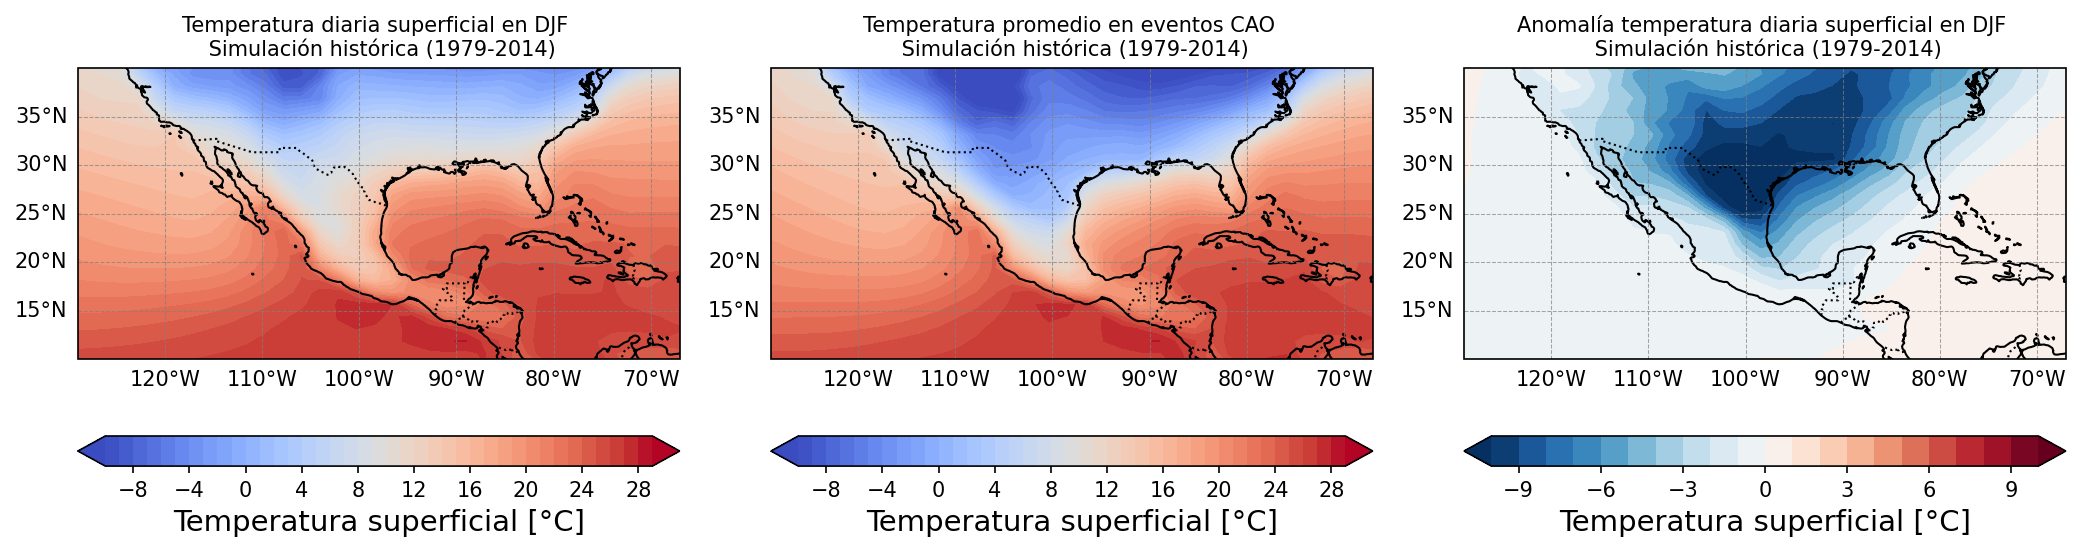

In [60]:
plt.figure(figsize=(14, 4), dpi=150)
plt.subplots_adjust(wspace=0.35)

# Subplot 1 YA OK -------------------------------------------------------------------------------------------
ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax1.coastlines()
#datatemp, lon = add_cyclic_point(tas_djf, coord=lons)
cs = ax1.contourf(lonsHG, latsHG, tas_djf, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax1.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=14)
plt.title('Temperatura diaria superficial en DJF \n Simulación histórica (1979-2014)', fontsize=10)

# Subplot 2  YA OK ----------------------------------------------------------------------
ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax2.coastlines()
cs = ax2.contourf(lonsHG, latsHG, tempsCAOHG, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax2.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax2)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=14)
plt.title('Temperatura promedio en eventos CAO \n Simulación histórica (1979-2014)', fontsize=10)

# Subplot 3 YA OK ----------------------------------------------------------------------------------------------
ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
ax3.coastlines()
#datatemp, lon = add_cyclic_point(anomaliaHG, coord=lons)
cs = ax3.contourf(lonsHG, latsHG, anomaliaHG, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax3.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax3)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=14)
plt.title('Anomalía temperatura diaria superficial en DJF \n Simulación histórica (1979-2014)', fontsize=10)

plt.tight_layout(h_pad=2, pad=1)
plt.show()

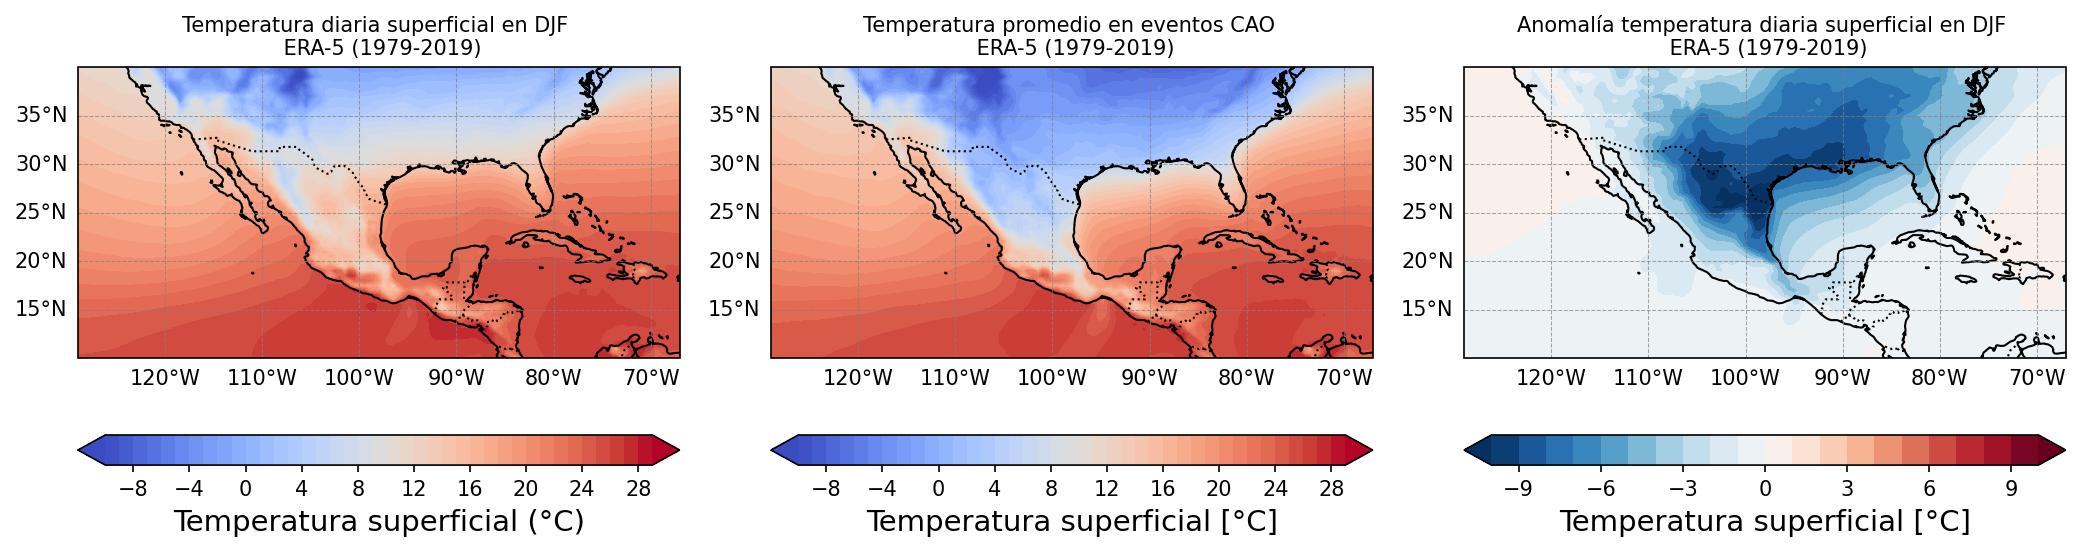

In [61]:
plt.figure(figsize=(14, 4), dpi=150)
plt.subplots_adjust(wspace=0.35)

# Subplot 1
ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax1.coastlines()
cs = ax1.contourf(lonsE5_t, latsE5_t, invs_E5, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax1.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax1)
cbar.ax.set_xlabel('Temperatura superficial (°C)', fontsize=14)
plt.title('Temperatura diaria superficial en DJF \n ERA-5 (1979-2019)', fontsize=10)

# Subplot 2
ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax2.coastlines()
cs = ax2.contourf(lonsE5_t, latsE5_t,tempsCAOE5, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax2.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax2)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=14)
plt.title('Temperatura promedio en eventos CAO \n ERA-5 (1979-2019)', fontsize=10)

# Subplot 3
ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
ax3.coastlines()
cs = ax3.contourf(lonsE5_t, latsE5_t, E5_anomalia, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax3.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax3)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=14)
plt.title('Anomalía temperatura diaria superficial en DJF \n ERA-5 (1979-2019)', fontsize=10)

plt.tight_layout(h_pad=2, pad=1)
plt.show()


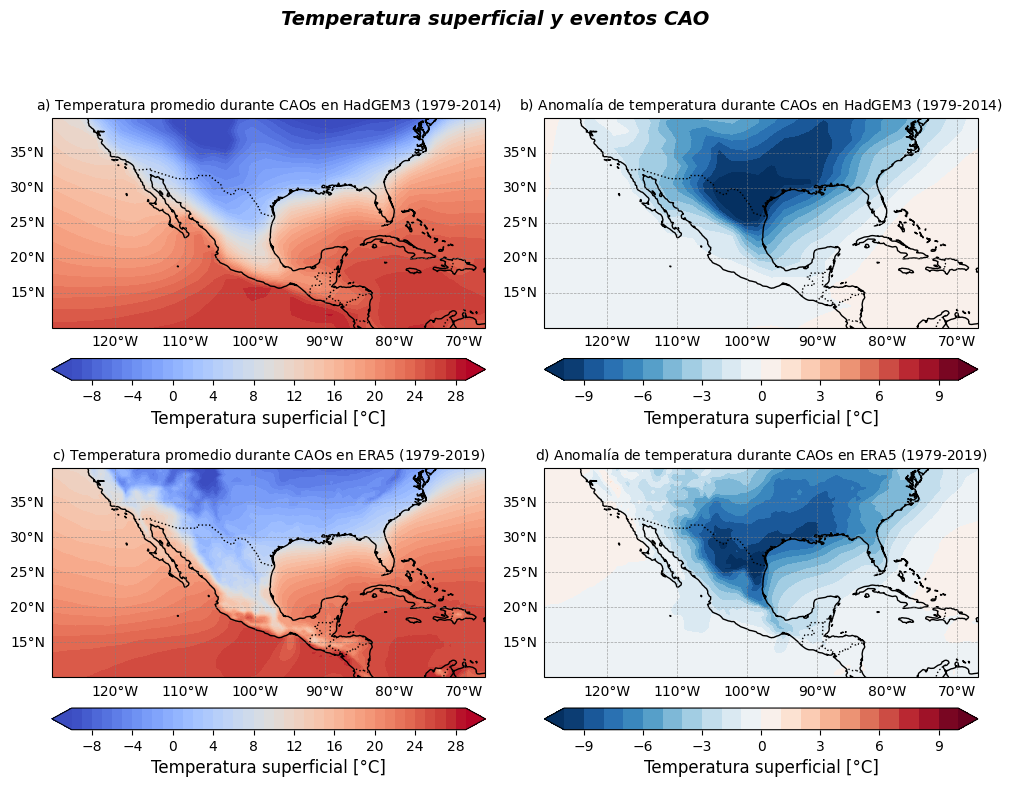

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})#, constrained_layout=True)
plt.subplots_adjust(wspace=0.2, hspace=0.45)
axs = axs.flatten()

# Subplot 1: Temperatura promedio en eventos CAO - Simulación histórica
ax = axs[0]
ax.coastlines()
cs = ax.contourf(lonsHG, latsHG, tempsCAOHG, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=12)
ax.set_title('a$)$ Temperatura promedio durante CAOs en HadGEM3 (1979-2014)', fontsize=10)

# Subplot 2: Anomalía de temperatura diaria en DJF - Simulación histórica
ax = axs[1]
ax.coastlines()
cs = ax.contourf(lonsHG, latsHG, anomaliaHG, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=12)
ax.set_title('b$)$ Anomalía de temperatura durante CAOs en HadGEM3 (1979-2014)', fontsize=10)

# Subplot 3: Temperatura promedio en eventos CAO - ERA-5
ax = axs[2]
ax.coastlines()
cs = ax.contourf(lonsE5_t, latsE5_t, tempsCAOE5, levels=np.arange(-10, 30, 1), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=12)
ax.set_title('c$)$ Temperatura promedio durante CAOs en ERA5 (1979-2019)', fontsize=10)

# Subplot 4: Anomalía de temperatura diaria en DJF - ERA-5
ax = axs[3]
ax.coastlines()
cs = ax.contourf(lonsE5_t, latsE5_t, E5_anomalia, levels=np.arange(-10, 10.1, 1), cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.set_extent([231, 293, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Temperatura superficial [°C]', fontsize=12)
ax.set_title('d$)$ Anomalía de temperatura durante CAOs en ERA5 (1979-2019)', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=.89)
plt.suptitle('Temperatura superficial y eventos CAO', fontsize=14, color="k", fontstyle='italic', fontweight='bold')
#plt.show()

plt.savefig('temp_CAOs.png')

###### <h1  style="color:purple; font-size:20px;"><i> Climatología de viento vs viento en CAO </i> </h1>

In [ ]:
plt.figure(figsize=(14, 4), dpi=150)
plt.subplots_adjust(wspace=0.35)

# Subplot 1
ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax1.coastlines()
cs = ax1.contourf(lonsuHG, latsuHG, u_DJFHG, levels=np.arange(0, 50,1), cmap=cm.lajolla_r, extend='max', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax1.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=14)
plt.title('Viento zonal diario (200 hPa) en DJF \n Simulación histórica (1979-2014)', fontsize=10)

# Subplot 2
ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax2.coastlines()
cs = ax2.contourf(lonsuHG, latsuHG, vientoCAOHG, levels=np.arange(0, 50, 1), cmap=cm.lajolla_r, extend='max', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax2.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax2)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$) ', fontsize=14)
plt.title('Viento zonal promedio (200 hPa) durante eventos CAO \n Simulación histórica (1979-2014)', fontsize=10)

# Subplot 3
ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
ax3.coastlines()
cs = ax3.contourf(lonsuHG, latsuHG, u_anomaliaHG, levels=np.arange(-15, 15, 1), cmap='PiYG', extend='both', transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax3.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax3)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=14)
plt.title('Anomalía de viento zonal en DJF \n Simulación histórica (1979-2014)', fontsize=10)

plt.tight_layout(h_pad=2, pad=1)
plt.show()


In [ ]:
plt.figure(figsize=(14, 4), dpi=150)
plt.subplots_adjust(wspace=0.35)

# Subplot 1
ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax1.coastlines()
cs = ax1.contourf(lonsuE5, latsuE5, uE5_DJF, levels=np.arange(0, 50,1), cmap=cm.lajolla_r, extend='max', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax1.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=14)
plt.title('Viento zonal diario (200 hPa) en DJF \n Simulación histórica (1979-2014)', fontsize=10)

# Subplot 2
ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax2.coastlines()
cs = ax2.contourf(lonsuE5, latsuE5, vientoCAOE5, levels=np.arange(0, 50, 1), cmap=cm.lajolla_r, extend='max', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax2.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax2)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$) ', fontsize=14)
plt.title('Viento zonal promedio (200 hPa) durante eventos CAO \n Simulación histórica (1979-2014)', fontsize=10)

# Subplot 3
ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
ax3.coastlines()
cs = ax3.contourf(lonsuE5, latsuE5, u_anomaliaE5, levels=np.arange(-15, 15, 1), cmap='PiYG', extend='both', transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax3.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
plt.minorticks_on()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.1, ax=ax3)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=14)
plt.title('Anomalía de viento zonal en DJF \n Simulación histórica (1979-2014)', fontsize=10)

plt.tight_layout(h_pad=2, pad=1)
plt.show()


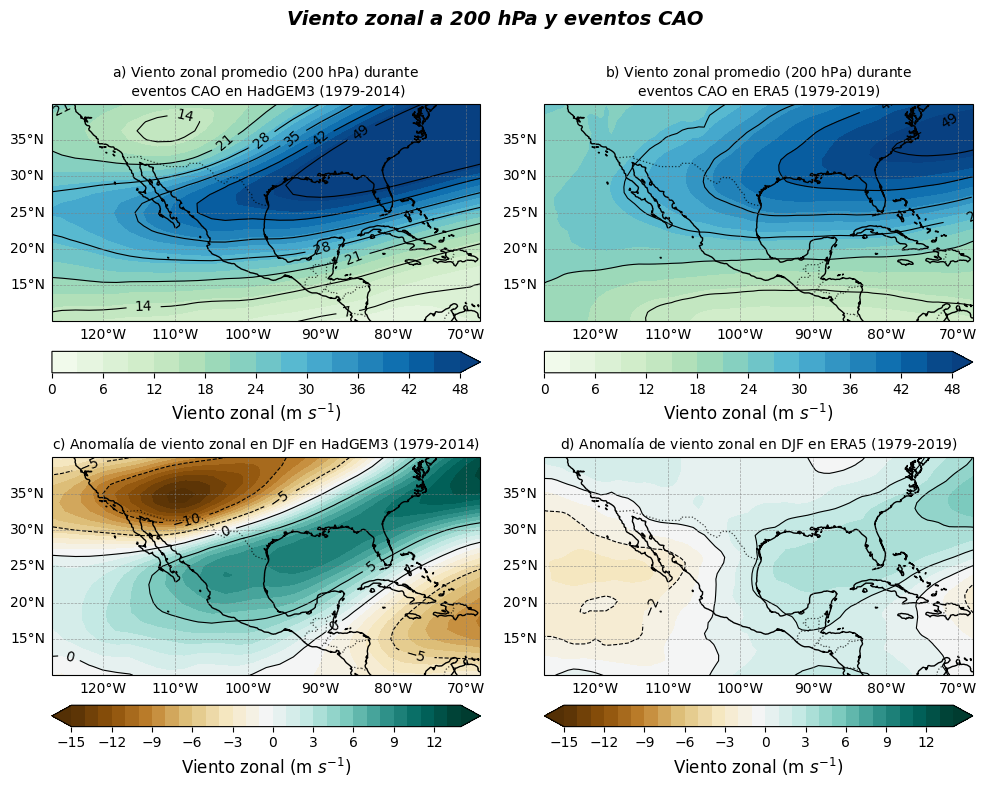

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})#, constrained_layout=True)
plt.subplots_adjust(wspace=0.2, hspace=0.45)
axs = axs.flatten()

# Subplot 1: Viento zonal promedio durante eventos CAO - Simulación histórica
ax = axs[0]
ax.coastlines()
cs = ax.contourf(lonsuHG, latsuHG, vientoCAOHG, levels=np.arange(0, 50, 3), cmap='GnBu', extend='max', transform=ccrs.PlateCarree())
cc = ax.contour(lonsuHG, latsuHG, vientoCAOHG, levels=np.arange(0, 50, 7), colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9, alpha=0.7)
ax.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=12)
ax.set_title('a$)$ Viento zonal promedio (200 hPa) durante \n eventos CAO en HadGEM3 (1979-2014)', fontsize=10)

# Subplot 2: Anomalía de viento zonal en DJF - Simulación histórica
ax = axs[2]
ax.coastlines()
cs = ax.contourf(lonsuHG, latsuHG, u_anomaliaHG, levels=np.arange(-15, 15, 1), cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
cc = ax.contour(lonsuHG, latsuHG, u_anomaliaHG, levels=np.arange(-10, 10, 5), colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9, alpha=0.7)
ax.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=12)
ax.set_title('c$)$ Anomalía de viento zonal en DJF en HadGEM3 (1979-2014)', fontsize=10)

# Subplot 3: Viento zonal promedio durante eventos CAO - ERA-5
ax = axs[1]
ax.coastlines()
cs = ax.contourf(lonsuE5, latsuE5, vientoCAOE5, levels=np.arange(0, 50, 3), cmap='GnBu', extend='max', transform=ccrs.PlateCarree())
cc = ax.contour(lonsuE5, latsuE5,  vientoCAOE5, levels=np.arange(0, 50, 7), colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9, alpha=0.7)
ax.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=12)
ax.set_title('b$)$ Viento zonal promedio (200 hPa) durante \neventos CAO en ERA5 (1979-2019)', fontsize=10)

# Subplot 4: Anomalía de viento zonal en DJF - ERA-5
ax = axs[3]
ax.coastlines()
cs = ax.contourf(lonsuE5, latsuE5, u_anomaliaE5, levels=np.arange(-15, 15, 1), cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
cc = ax.contour(lonsuE5, latsuE5,  u_anomaliaE5, levels=np.arange(-10, 10, 2), colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
ax.clabel(cc, cc.levels, inline=True, fontsize=10)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9, alpha=0.7)
ax.set_extent([233, 292, 10, 40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.7, linestyle='--', linewidth=0.5)
gl.top_labels = gl.right_labels = False
cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=0.1, pad=0.1)
cbar.ax.set_xlabel('Viento zonal (m $s^{-1}$)', fontsize=12)
ax.set_title('d$)$ Anomalía de viento zonal en DJF en ERA5 (1979-2019)', fontsize=10)

# plt.show()
plt.tight_layout()
plt.subplots_adjust(top=.89)
plt.suptitle('Viento zonal a 200 hPa y eventos CAO', fontsize=14, color="k", fontstyle='italic', fontweight='bold')

plt.savefig('vientoyCAOs')